<a href="https://colab.research.google.com/github/cosminluciantuiasi/dissertation/blob/feature%2Ffacial-recognition-part1/face_recognition_part1_hyperparam_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import fnmatch
from google.colab.patches import cv2_imshow
import os
import cv2
from google.colab import drive
from IPython.display import clear_output
import time
import glob
import random
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms.functional import to_tensor, normalize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch.nn as nn
import torch
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import Compose, ToTensor, RandomHorizontalFlip, RandomResizedCrop, ColorJitter, Grayscale

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
!ls '/content/drive/MyDrive/Colab Notebooks/disertation/transformed_yale_extended2'

yaleB11  yaleB16  yaleB20  yaleB24  yaleB28  yaleB32  yaleB36
yaleB12  yaleB17  yaleB21  yaleB25  yaleB29  yaleB33  yaleB37
yaleB13  yaleB18  yaleB22  yaleB26  yaleB30  yaleB34  yaleB38
yaleB15  yaleB19  yaleB23  yaleB27  yaleB31  yaleB35  yaleB39


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/disertation/dataset/ExtendedYaleB.zip' -d /tmp

Streaming output truncated to the last 5000 lines.
  inflating: /tmp/ExtendedYaleB/yaleB33/yaleB33_P00A+005E+10.pgm  
  inflating: /tmp/ExtendedYaleB/yaleB33/yaleB33_P02A+000E+20.pgm  
  inflating: /tmp/ExtendedYaleB/yaleB33/yaleB33_P05A+035E+40.pgm  
  inflating: /tmp/ExtendedYaleB/yaleB33/yaleB33_P08A-110E+40.pgm  
  inflating: /tmp/ExtendedYaleB/yaleB33/yaleB33_P03A+020E-10.pgm  
  inflating: /tmp/ExtendedYaleB/yaleB33/yaleB33_P06A+060E+20.pgm  
  inflating: /tmp/ExtendedYaleB/yaleB33/yaleB33_P00A+085E+20.pgm  
  inflating: /tmp/ExtendedYaleB/yaleB33/yaleB33_P08A+070E+00.pgm  
  inflating: /tmp/ExtendedYaleB/yaleB33/yaleB33_P08A+050E+00.pgm  
  inflating: /tmp/ExtendedYaleB/yaleB33/yaleB33_P07A+000E+90.pgm  
  inflating: /tmp/ExtendedYaleB/yaleB33/yaleB33_P03A-035E+40.pgm  
  inflating: /tmp/ExtendedYaleB/yaleB33/yaleB33_P03A+020E+10.pgm  
  inflating: /tmp/ExtendedYaleB/yaleB33/yaleB33_P06A-005E+10.pgm  
  inflating: /tmp/ExtendedYaleB/yaleB33/yaleB33_P07A+095E+00.pgm  
  inflating

In [ ]:
# Load the cascade
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Colab Notebooks/disertation/misc/haar.xml')

In [ ]:
extensions = ['*.jpg', '*.png', '*.jpeg', '*.pgm']
#CV2 Cascade Classifier hyperparams
scaleFactor = 1.1
minNeighbors = 4

def detect_faces_in_dataset(input_path, output_path):
  if not os.path.exists(input_path) or not os.path.exists(output_path):
    print('Provided file paths dont exist.')
    return
  for root,_,files in os.walk(input_path):
    print(root)
    if root==input_path:
      continue

    subclass = root.split('/')[-1]
    subclass_path = output_path+'/'+subclass

    if not os.path.exists(subclass_path):
      os.mkdir(subclass_path)

    for filename in files:
      print(filename)
      file = os.path.join(root,filename)
      counter=0
      if any(fnmatch.fnmatch(file, extension) for extension in extensions):
        img = cv2.imread(file)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Detect faces coords
        faces = face_cascade.detectMultiScale(gray_img, scaleFactor = scaleFactor, minNeighbors = minNeighbors)
        # Draw rectangle around the faces
        for (x, y, w, h) in faces:
          crop_face = img[y:y+h, x:x+w]
          new_filename = '.'.join([filename.split('.')[0] + "_" + str(counter),'png'])

          file_path = '/'.join(root.split('/')[:-1])
          file_path = os.path.join(output_path+'/'+subclass,new_filename)
          print(file_path)
          cv2.imwrite(file_path,crop_face)
          print(f"Saved {file_path}.")

          counter+=1
          break
        if len(faces)==0:
          print(f'No face detected on {filename}')

In [ ]:
# input_path = "/content/drive/MyDrive/Colab Notebooks/disertation/dataset/test_images"
# output_path = "/content/drive/MyDrive/Colab Notebooks/disertation/dataset/transformed_images"
# detect_faces_in_dataset(input_path, output_path)

In [ ]:
!mkdir '/content/drive/MyDrive/Colab Notebooks/disertation/transformed_yale_extended2'

In [ ]:
# input_path = "/tmp/PINS"
# output_path = "/tmp/transformed_pins"


input_path = "/tmp/ExtendedYaleB"
output_path = "/content/drive/MyDrive/Colab Notebooks/disertation/transformed_yale_extended2"

In [ ]:
detect_faces_in_dataset(input_path, output_path)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Colab Notebooks/disertation/transformed_yale_extended2/yaleB35/yaleB35_P01A+010E+00_0.png
Saved /content/drive/MyDrive/Colab Notebooks/disertation/transformed_yale_extended2/yaleB35/yaleB35_P01A+010E+00_0.png.
yaleB35_P06A+110E-20.pgm
No face detected on yaleB35_P06A+110E-20.pgm
yaleB35_P01A-060E+20.pgm
/content/drive/MyDrive/Colab Notebooks/disertation/transformed_yale_extended2/yaleB35/yaleB35_P01A-060E+20_0.png
Saved /content/drive/MyDrive/Colab Notebooks/disertation/transformed_yale_extended2/yaleB35/yaleB35_P01A-060E+20_0.png.
yaleB35_P04A+035E+40.pgm
/content/drive/MyDrive/Colab Notebooks/disertation/transformed_yale_extended2/yaleB35/yaleB35_P04A+035E+40_0.png
Saved /content/drive/MyDrive/Colab Notebooks/disertation/transformed_yale_extended2/yaleB35/yaleB35_P04A+035E+40_0.png.
yaleB35_P03A+060E+20.pgm
/content/drive/MyDrive/Colab Notebooks/disertation/transformed_yale_extended2/yaleB35/yaleB35_P03A+060E+2

In [ ]:
!find '/content/drive/MyDrive/Colab Notebooks/disertation/transformed_yale_extended2' | wc -l
# !find /tmp/PINS/ | wc -l

12289


In [ ]:
# !rm -r /tmp/transformed_pins/

In [ ]:
class FacesDataset(Dataset):
    def __init__(self, file_list, dataset_path, width=128, height=128, transform=None):
        self.file_list = file_list
        self.transform = transform
        self.img_size = (width, height)
        self.dataset_path = dataset_path
         # Default transform without augmentation
        self.default_transform = Compose([
            ToTensor(),
        ])


    def __len__(self):
        return len(self.file_list)

    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)

        original_width, original_height = img.size

        img = img.resize(self.img_size)
        img = np.array(img)
        label = img_path.split('/')
        label_name = label[-2]

        labels = os.listdir(self.dataset_path)
        labels.sort()
        label = labels.index(label[-2])

        if self.transform:
            img = self.transform(img)
        else:
            img = self.default_transform(img)

        return img, (label,label_name)

In [ ]:
def collate_fn(examples):
  processed_images = []
  processed_labels = []

  for example in examples:
    tensor_image = example[0]

    grayscale_tensor_image = Grayscale()(tensor_image)

    normalized_tensor_image = normalize(grayscale_tensor_image, [0.5], [0.5])
    normalized_tensor_image = normalized_tensor_image.unsqueeze(0)
    processed_images.append(normalized_tensor_image)
    label = np.array(example[1][0])

    tensor_label = torch.tensor(label)
    tensor_label = tensor_label.unsqueeze(0)
    processed_labels.append(tensor_label)


  torch_images = torch.cat(processed_images, dim=0)
  torch_labels = torch.cat(processed_labels, dim=0)
  return torch_images, torch_labels

In [ ]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

num_classes = 28

train_transform = Compose([
    RandomHorizontalFlip(p=0.5),                           # Random horizontal flip
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Random color jitter
    ToTensor(),                                            # Convert the image to a tensor
])

file_list = glob.glob(os.path.join(output_path+'/*','*.png'))
random.shuffle(file_list)

dataset = FacesDataset(file_list, output_path, transform=None)

dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

print(dataset_size, train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=1, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=1, collate_fn=collate_fn)



12260 8582 1839 1839


In [ ]:
print(train_dataset)

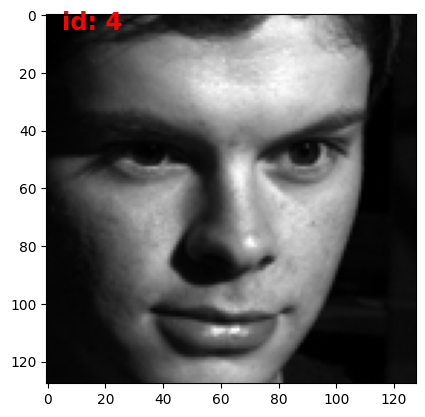

In [ ]:
see_examples = 20
for i, (imgs, label_id) in enumerate(train_loader):
  clear_output(wait=True)
  plt.imshow(imgs[0].permute(1, 2, 0)[:,:,0],cmap='gray')
  plot_text = f'id: {str(label_id[0].item())}'
  plt.text(5, 5, plot_text, fontsize ='xx-large', color='red', fontweight='bold')
  plt.show()

  if i >= see_examples - 1:
    break
  time.sleep(1)

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self , in_channels , out_channels , kernel_size , stride , padding, mp_kernel_size, mp_stride):
    super(ConvBlock , self).__init__()
    self.conv = nn.Conv2d(in_channels , out_channels , kernel_size , stride, padding)
    self.activation = nn.ReLU()
    self.dropout = nn.Dropout(p=0.2)
    self.max_pool2d = nn.MaxPool2d(kernel_size = mp_kernel_size, stride = mp_stride)

  def forward(self , x):
    out = self.conv(x)
    out = self.activation(out)
    out = self.dropout(out)
    out = self.max_pool2d(out)
    return out

class FacesModel(nn.Module):
  def __init__(self):
    super(FacesModel, self).__init__()
    self.seq = nn.Sequential(
        ConvBlock(1,32,kernel_size=3, stride=1, padding=1, mp_kernel_size=2, mp_stride=2),
        ConvBlock(32,64,kernel_size=3, stride=1, padding=1, mp_kernel_size=2, mp_stride=2),
        ConvBlock(64,96,kernel_size=3, stride=1, padding=1, mp_kernel_size=2, mp_stride=2),
        ConvBlock(96,128,kernel_size=3, stride=1, padding=1, mp_kernel_size=2, mp_stride=2),
        nn.Dropout(p=0.5),
        nn.Flatten(),
        nn.Linear(in_features=8192 ,out_features= 512),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=512 ,out_features= num_classes)
    )
  def forward(self , x):
   out = self.seq(x)
   return out

In [ ]:
faces_model = FacesModel().to(device)
summary(faces_model,(1,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
              ReLU-2         [-1, 32, 128, 128]               0
           Dropout-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
         ConvBlock-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
              ReLU-7           [-1, 64, 64, 64]               0
           Dropout-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
        ConvBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 96, 32, 32]          55,392
             ReLU-12           [-1, 96, 32, 32]               0
          Dropout-13           [-1, 96, 32, 32]               0
        MaxPool2d-14           [-1, 96,

In [ ]:
faces_model

FacesModel(
  (seq): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.2, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.2, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout): Dropout(p=0.2, inplace=False)
      (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): ConvBlock(
      (conv): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
      (dropout)

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def val_loop(val_loader, model, loss_fn, cuda_check):
  #set model to val mode
  model.eval()
  size = len(val_loader.dataset)
  num_batches = len(val_loader)
  val_loss, correct = 0, 0

  #make sure no gradient is computed in validation phase
  with torch.no_grad():
    for val_images, val_labels in val_loader:
      if cuda_check==True:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)
      pred = model(val_images)
      val_loss += loss_fn(pred, val_labels).item()
      correct += torch.sum(torch.argmax(pred,dim=1) == val_labels)
  val_loss /= num_batches
  correct = float(correct)/ float(size)
  print(f"Validation: \n Val - Accuracy: {(100*correct):>0.1f}%, Val - loss: {val_loss:>8f};\n")
  return correct, val_loss

def train_loop(train_loader, model, optimizer, loss_fn, cuda_check):
  size = len(train_loader.dataset)
  running_loss, last_loss = 0.0, 0.0
  report_step = 50

  #set model to train mode - useful for batch norm or dropout
  model.train()
  for counter, (train_images, train_labels) in enumerate(train_loader):
    if cuda_check:
      train_images = train_images.to(device)
      train_labels = train_labels.to(device)

    optimizer.zero_grad()
    pred = model(train_images)
    train_loss = loss_fn(pred, train_labels)
    train_loss.backward()
    optimizer.step()

    running_loss += train_loss.item()
    if counter % report_step == 0:
      last_loss = running_loss / report_step if counter !=0 else running_loss
      processed_images =  (counter+1) * len(train_images)
      print(f"Training loss: {last_loss:>7f}  [{processed_images:>5d}/{size:>5d}]")
      running_loss = 0.0
  return last_loss


In [ ]:
early_stopper = EarlyStopper(patience=3, min_delta=0)
cuda_check=True

faces_model = FacesModel().to(device)
epochs = 30
learning_rate = 1e-4
optimizer = optim.Adam(faces_model.parameters(), lr=learning_rate)
optimizer.zero_grad()
loss_fn = nn.CrossEntropyLoss()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

try:
  for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    train_loss = train_loop(train_loader, faces_model, optimizer, loss_fn, cuda_check)
    val_correct, val_loss = val_loop(val_loader, faces_model, loss_fn, cuda_check)

    val_accuracy = 100 * val_correct / len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if early_stopper.early_stop(val_loss):
      print('Stopped by EarlyStop mechanism!')
      break

  print("Done!")
except AssertionError as e:
    if str(e) == 'can only test a child process':
        pass  # Ignore the assertion error
    else:
        raise e

Epoch 1
-------------------------------
Training loss: 3.329130  [   16/ 8582]
Training loss: 3.194644  [  816/ 8582]
Training loss: 3.011690  [ 1616/ 8582]
Training loss: 2.926189  [ 2416/ 8582]
Training loss: 2.884279  [ 3216/ 8582]
Training loss: 2.742285  [ 4016/ 8582]
Training loss: 2.683365  [ 4816/ 8582]
Training loss: 2.663510  [ 5616/ 8582]
Training loss: 2.537609  [ 6416/ 8582]
Training loss: 2.358307  [ 7216/ 8582]
Training loss: 2.222310  [ 8016/ 8582]
Validation: 
 Val - Accuracy: 54.0%, Val - loss: 2.280099;

Epoch 2
-------------------------------
Training loss: 1.352299  [   16/ 8582]
Training loss: 1.859681  [  816/ 8582]
Training loss: 1.907563  [ 1616/ 8582]
Training loss: 1.623902  [ 2416/ 8582]
Training loss: 1.496811  [ 3216/ 8582]
Training loss: 1.538214  [ 4016/ 8582]
Training loss: 1.269159  [ 4816/ 8582]
Training loss: 1.273076  [ 5616/ 8582]
Training loss: 1.292846  [ 6416/ 8582]
Training loss: 1.218634  [ 7216/ 8582]
Training loss: 1.113569  [ 8016/ 8582]
Va

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7f6ba401f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation: 
 Val - Accuracy: 94.6%, Val - loss: 0.288546;

Epoch 16
-------------------------------
Training loss: 0.059169  [   16/ 8582]
Training loss: 0.118848  [  816/ 8582]
Training loss: 0.133902  [ 1616/ 8582]
Training loss: 0.158623  [ 2416/ 8582]
Training loss: 0.159099  [ 3216/ 8582]
Training loss: 0.091788  [ 4016/ 8582]
Training loss: 0.116544  [ 4816/ 8582]
Training loss: 0.119410  [ 5616/ 8582]
Training loss: 0.117798  [ 6416/ 8582]
Training loss: 0.114590  [ 7216/ 8582]
Training loss: 0.136425  [ 8016/ 8582]
Validation: 
 Val - Accuracy: 93.9%, Val - loss: 0.278331;

Epoch 17
-------------------------------
Training loss: 0.006385  [   16/ 8582]
Training loss: 0.137563  [  816/ 8582]
Training loss: 0.147261  [ 1616/ 8582]
Training loss: 0.130397  [ 2416/ 8582]
Training loss: 0.130711  [ 3216/ 8582]
Training loss: 0.111097  [ 4016/ 8582]
Training loss: 0.127986  [ 4816/ 8582]
Training loss: 0.114595  [ 5616/ 8582]
Training loss: 0.141923  [ 6416/ 8582]
Training loss: 0.1

In [ ]:
def test_model(model, test_loader, cuda_check):
    total = 0
    correct = 0

    model.eval()
    with torch.no_grad():
      for i, (x, y) in enumerate(test_loader):
        if cuda_check:
          x = x.to(device)
          y = y.to(device)

        pred = model(x)
        correct += torch.sum(pred.argmax(dim=1) == y)
        total += len(x)

        if i % 50 == 0:
          print(f"Correct: {int(correct)}, Total checked: {total}")

    accuracy = correct / total
    print(f"Accuracy: {correct} / {total} = {accuracy:.2%}")

    return accuracy

In [ ]:
test_acc = test_model(faces_model, test_loader, cuda_check)

Correct: 1, Total checked: 1
Correct: 49, Total checked: 51
Correct: 96, Total checked: 101
Correct: 145, Total checked: 151
Correct: 192, Total checked: 201
Correct: 239, Total checked: 251
Correct: 286, Total checked: 301
Correct: 335, Total checked: 351
Correct: 382, Total checked: 401
Correct: 432, Total checked: 451
Correct: 480, Total checked: 501
Correct: 525, Total checked: 551
Correct: 570, Total checked: 601
Correct: 618, Total checked: 651
Correct: 665, Total checked: 701
Correct: 712, Total checked: 751
Correct: 757, Total checked: 801
Correct: 806, Total checked: 851
Correct: 855, Total checked: 901
Correct: 900, Total checked: 951
Correct: 950, Total checked: 1001
Correct: 999, Total checked: 1051
Correct: 1048, Total checked: 1101
Correct: 1094, Total checked: 1151
Correct: 1142, Total checked: 1201
Correct: 1189, Total checked: 1251
Correct: 1237, Total checked: 1301
Correct: 1284, Total checked: 1351
Correct: 1329, Total checked: 1401
Correct: 1378, Total checked: 1451

In [ ]:
def plot_training_results(epochs_range, train_losses, val_losses, val_accuracies):
    # Plotting
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

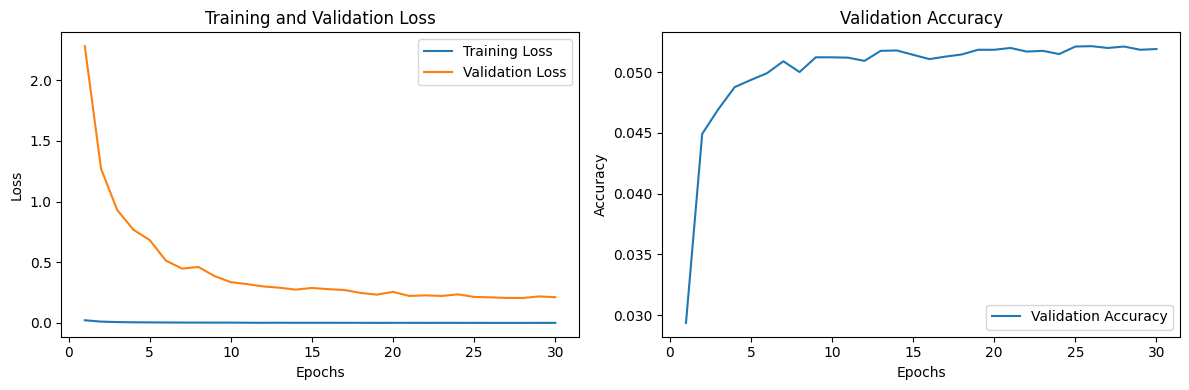

In [ ]:
epochs_range = range(1, epochs + 1)
train_losses = [float(loss) for loss in train_losses]
val_losses = [float(loss) for loss in val_losses]
val_accuracies = [float(acc) for acc in val_accuracies]

train_losses = np.array(train_losses)/100

plot_training_results(epochs_range, train_losses, val_losses, val_accuracies)